In [1]:
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision.transforms as transform

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_index = pd.read_csv('./archive/train.csv',header=None)
train_index.columns = ['image','label']

In [4]:
image_path = './archive/images/'+train_index['image'][0]
label_path = './archive/labels/'+train_index['label'][0]

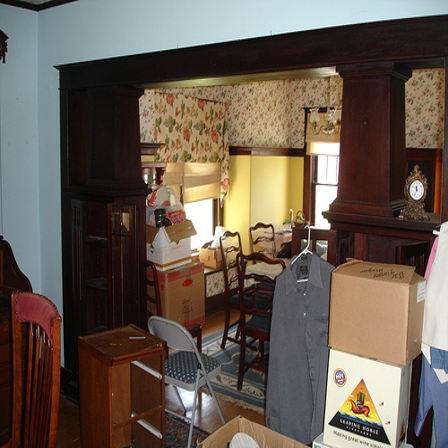

In [5]:
img = Image.open(image_path).convert("RGB")
img = img.resize((448,448))
img

In [6]:
labels = []
boxes = []
with open(label_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        res = line.strip().split(' ')
        labels.append(res[0])
        boxes.append([float(i) for i in [res[1],res[2],res[3],res[4]]])

In [7]:
def xyxy(boxes):
    xyxy = []
    for i in boxes:
        x1 = img.size[0]*i[0]-img.size[0]*i[2]/2
        x2 = img.size[0]*i[0]+img.size[0]*i[2]/2
        y1 = img.size[1]*i[1]-img.size[1]*i[3]/2
        y2 = img.size[1]*i[1]+img.size[1]*i[3]/2
        xyxy.append([x1,x2,y1,y2])
    return xyxy

In [8]:
convert_boxes = xyxy(boxes)

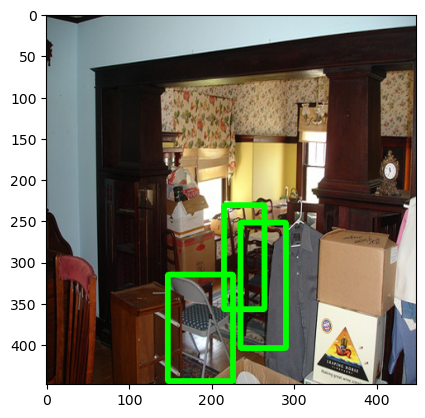

In [9]:
img_clone = np.copy(img)
for i in range(len(convert_boxes)):
    cv2.rectangle(img_clone, (int(convert_boxes[i][0]), int(convert_boxes[i][2])), (int(convert_boxes[i][1]), int(convert_boxes[i][3])), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

In [10]:
def make_target(labels,boxes,split):
    target = np.zeros((split,split,20+5))

    for n in range(len(labels)):
        i,j = int(boxes[n][0]*split),int(boxes[n][1]*split)
        box_coord = [boxes[n][0]*split-i,boxes[n][1]*split-j,boxes[n][2]*split,boxes[n][3]*split]
        target[i,j,int(labels[n])-1]=1
        target[i,j,-5] = 1
        target[i,j,-4:] = box_coord
    
    return target

In [11]:
target = make_target(labels,boxes,7)

## YOLO Modeling

In [12]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [13]:
class conv_block(nn.Module):
    
    def __init__(self,in_channels,out_channels,**kwargs):
        super(conv_block,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,bias=False,**kwargs,)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
    
    def forward(self,x):
        x = self.leaky_relu(self.bn(self.conv(x)))
        return x

In [14]:
class Yolov1(nn.Module):
    def __init__(self,config,in_channels=3,**kwargs):
        super(Yolov1,self).__init__()

        self.config = config
        self.in_channels = in_channels
        self.darknet = self.create_conv_layers(self.in_channels)
        self.fcnet = self.create_fc_layers(**kwargs)
        
    def create_conv_layers(self,in_channels):
        conv_layers=[]
        for x in self.config:
            if x == "M":
                conv_layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
            elif type(x) == list:
                for i in range(x[-1]):
                    conv_layers.append(conv_block(in_channels,x[0][1],kernel_size=x[0][0],stride=x[0][2],padding=x[0][3]))
                    conv_layers.append(conv_block(x[0][1],x[1][1],kernel_size=x[1][0],stride=x[1][2],padding=x[1][3]))
                    in_channels = x[1][1]
            else:
                conv_layers.append(conv_block(in_channels,x[1],kernel_size=x[0],stride=x[2],padding=x[3]))
                in_channels = x[1]
        return nn.Sequential(*conv_layers)

    def create_fc_layers(self,split_size,num_boxes,num_classes):
        s,b,c = split_size,num_boxes,num_classes
        fc_layers=nn.Sequential(
            nn.Flatten(),
            nn.Linear(s*s*1024,4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096,s*s*(5*b+c))
        )
        return fc_layers

    def forward(self,x):
        x1 = torch.flatten(self.darknet(x),start_dim = 1)
        x2 = self.fcnet(x1)
        return x2

In [15]:
model = Yolov1(architecture_config, split_size=7, num_boxes=2, num_classes=20).to(device)
model

Yolov1(
  (darknet): Sequential(
    (0): conv_block(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): conv_block(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): conv_block(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (5): conv_block(
      (

In [16]:
img_tensor = torch.Tensor(img_clone).permute(2,0,1).view(1,3,448,448).to(device)
output = model(img_tensor)

### Utils

In [17]:
#utils
def IOU(pred,target,format = "midpoint"): 
    if format == "midpoint": #box의 표현방식이 center_x,center_y,height,width 이면 midpoint
        box1_x1 = pred[...,0:1] - pred[...,2:3]/2
        box1_x2 = pred[...,0:1] + pred[...,2:3]/2
        box1_y1 = pred[...,1:2] - pred[...,3:4]/2
        box1_y2 = pred[...,1:2] + pred[...,3:4]/2
        
        box2_x1 = target[...,0:1] - target[...,2:3]/2
        box2_x2 = target[...,0:1] + target[...,2:3]/2
        box2_y1 = target[...,1:2] - target[...,3:4]/2
        box2_y2 = target[...,1:2] + target[...,3:4]/2

    x1 = torch.max(box1_x1, box2_x1)[0]
    y1 = torch.max(box1_y1, box2_y1)[0]
    x2 = torch.min(box1_x2, box2_x2)[0]
    y2 = torch.min(box1_y2, box2_y2)[0]
    
    inter = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1 = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2 = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    union = box1 + box2 - inter + 1e-6
    
    iou = inter/union
    
    return iou

### LOSS

In [18]:
class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss,self).__init__()
        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        self.mse = nn.MSELoss(reduction="sum")
        
    def forward(self, p, t):
        p = p.reshape(-1,7,7,20+5*2)
        t_box = t[...,21:25]
        pred_box1,pred_box2 = p[...,21:25],p[...,26:30]
        pred_conf1,pred_conf2 = p[...,20].unsqueeze(-1),p[...,25].unsqueeze(-1)

        iou1 = IOU(pred_box1,t_box)
        iou2 = IOU(pred_box2,t_box)

        ious = torch.cat([iou1.unsqueeze(0),iou2.unsqueeze(0)],dim=0)
        iou_max_val, best_bbox = torch.max(ious, dim = 0) #max ious value, max ious box

        actual_obj = t[...,20].unsqueeze(-1)
        
        box_target = actual_obj*t_box
        box_target[...,2:] = torch.sqrt(box_target[...,2:]) #w,h는 loss에서 sqrt가 들어가야함.

        box_pred = actual_obj*(best_bbox*pred_box2 + (1-best_bbox)*pred_box1)
        box_pred[...,2:] = torch.sign(box_pred[...,2:]) * torch.sqrt(torch.abs(box_pred[...,2:]+1e-6))

        box_coord_loss = self.mse(
            torch.flatten(box_pred,end_dim=-2),
            torch.flatten(box_target,end_dim=-2)
        )

        conf_pred = actual_obj*(best_bbox*pred_conf2 + (1-best_bbox)*pred_conf1)
        
        obj_loss = self.mse(
            torch.flatten(conf_pred),
            torch.flatten(actual_obj)
        )

        #no object loss
        no_obj_loss = self.mse(
            torch.flatten((1 - actual_obj) * pred_conf1,start_dim = 1),
            torch.flatten((1 - actual_obj) * actual_obj,start_dim = 1)
        )
        
        no_obj_loss2 = self.mse(
            torch.flatten((1 - actual_obj) * pred_conf2,start_dim = 1),
            torch.flatten((1 - actual_obj) * actual_obj,start_dim = 1)
        )
        
        #class loss
        class_loss = self.mse(
            torch.flatten(actual_obj * p[..., :20],end_dim = -2),
            torch.flatten(actual_obj * t[..., :20],end_dim = -2)
        )
        
        loss = (
            self.lambda_coord * box_coord_loss +
            obj_loss +
            self.lambda_noobj * (no_obj_loss2 + no_obj_loss) +
            class_loss
        )
        
        return loss

In [19]:
loss = YoloLoss()
#loss(output,target)

### Dataset

In [20]:
class custom_dataset(Dataset):
    def __init__(self,path,s=7,mode='train',transformation = True,device=device):
        super(custom_dataset,self).__init__()
        self.path = path
        self.mode = mode
        self.s = s
        self.transformation = transformation
        self.device = device

        train_index = pd.read_csv(self.path + '/train.csv',header=None)[:500]
        train_index.columns = ['image','label']
        test_index = pd.read_csv(self.path + '/test.csv',header=None)[:30]
        test_index.columns = ['image','label']
        self.train_index = train_index
        self.test_index = test_index

    def load_data(self,label_path):
        labels = []
        boxes = []
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                res = line.strip().split(' ')
                labels.append(res[0])
                boxes.append([float(i) for i in [res[1],res[2],res[3],res[4]]])
        return labels, boxes

    def make_target(self, labels, boxes):
        split = self.s
        target = np.zeros((split,split,20+5))
    
        for n in range(len(labels)):
            i,j = int(boxes[n][0]*split),int(boxes[n][1]*split)
            box_coord = [boxes[n][0]*split-i,boxes[n][1]*split-j,boxes[n][2]*split,boxes[n][3]*split]
            target[i,j,int(labels[n])-1]=1
            target[i,j,-5] = 1
            target[i,j,-4:] = box_coord
            
        target = torch.tensor(target).to(self.device)
        return target

    def transformer(self,img):
        mytrans = transform.Compose([
                transform.Resize((448,448)),
                transform.ToTensor(),
            ])
        if self.transformation:
            return mytrans(img)
        else:
            return img
        
    
    def __getitem__(self,index):
        if self.mode == 'train':
            image_path = self.path + '/images/'+ self.train_index['image'][index]
            label_path = self.path + '/labels/'+ self.train_index['label'][index]
            
        elif self.mode == 'test':
            image_path = self.path + '/images/'+ self.test_index['image'][index]
            label_path = self.path + '/labels/'+ self.test_index['label'][index]
        
        l,b = self.load_data(label_path)
        t = self.make_target(l,b)
        img = Image.open(image_path).convert("RGB")
        img = self.transformer(img)
        img = img.to(self.device)
        return img,t

            
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_index['image'])
        elif self.mode == 'test':
            return len(self.test_index['image'])

In [21]:
train_dataset = custom_dataset(path = './archive',s=7,mode='train',transformation=True)
test_dataset = custom_dataset(path = './archive',s=7,mode='test',transformation=True)

In [22]:
train_loader = DataLoader(
        train_dataset,
        batch_size = 1,
        num_workers=0,
        shuffle=True,
        drop_last=False)

test_loader = DataLoader(
        test_dataset,
        batch_size = 1,
        num_workers=0,
        shuffle=False,
        drop_last=False)

In [25]:
seed = 123
torch.manual_seed(seed)

#model = Yolo()
num_epochs = 10
batch = 64

w8_decay = 0
optimizer = torch.optim.SGD(model.parameters(), lr = 2e-5, momentum = 0.9, weight_decay = 0.0005)

#loss
lossfn = YoloLoss()

#model
model = Yolov1(architecture_config, split_size=7, num_boxes=2, num_classes=20).to(device)

In [26]:
def train(loader=train_loader):

    for epoch in range(num_epochs):
        loop = tqdm(loader, leave=True)
        mean_loss=[]
        loss=0
        for b_id, (x,y) in enumerate(loop):
            optimizer.zero_grad()
            pred = model(x)
            loss = lossfn(pred,y)
            loss.backward()
            optimizer.step()
            
            l = loss.item()
            mean_loss.append(l)
            loop.set_postfix(loss = l)
            
        print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [27]:
train(train_loader)

100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.16it/s, loss=37.6]


Mean loss was 80.25364941485783


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.55it/s, loss=6.58]


Mean loss was 80.34619418113928


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.57it/s, loss=37.2]


Mean loss was 80.39096176939034


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.22it/s, loss=92.5]


Mean loss was 79.85264855345163


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.43it/s, loss=89.4]


Mean loss was 79.64961145682534


100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.59it/s, loss=105]


Mean loss was 80.37873393308577


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.43it/s, loss=99.5]


Mean loss was 79.84313212485446


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.55it/s, loss=77.2]


Mean loss was 80.00512760250706


100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.47it/s, loss=120]


Mean loss was 79.04056962759569


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.29it/s, loss=97.5]

Mean loss was 80.68736251066667


In [30]:
def test(loader=test_loader):
    loop = tqdm(loader,leave=True)
    mean_loss=[]
    with torch.no_grad():
        for b_id, (x,y) in enumerate(loop):
            pred = model(x)
            loss = lossfn(pred,y)
            l = loss.item()
            mean_loss.append(l)
    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [31]:
test(test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.06it/s]

Mean loss was 74.11248510265847


In [32]:
pred_img = next(iter(test_loader))[0]
pred = model(pred_img)

### Utils

In [33]:
def convert_pred(output):
    p = output.reshape(-1,7,7,20+5*2)
    pred_box1,pred_box2 = p[...,21:25],p[...,26:30]
    pred_conf1,pred_conf2 = p[...,20].permute(1,2,0),p[...,25].permute(1,2,0)
    pred_class = p[...,:20]

    scores = torch.cat([pred_conf1.unsqueeze(0),pred_conf2.unsqueeze(0)],dim=0)
    best_box = scores.argmax(0).unsqueeze(0)
    
    best_boxes = best_box*pred_box2 + (1-best_box)*pred_box1
    best_confs = best_box*pred_conf2 + (1-best_box)*pred_conf1
    best_class = pred_class.argmax(-1).unsqueeze(-1)

    convert_preds = torch.cat(
        [best_class,best_confs,best_boxes],dim=-1
    )
    return convert_preds

In [42]:
def pred_to_box(boxes,size = 448):
    for i,j in zip(range(boxes.shape[1]),range(boxes.shape[2])):
        x1 = size/boxes.shape[1]*i+size/boxes.shape[1]*boxes[...,0]-size*boxes[...,2]/2
        x2 = size/boxes.shape[1]*i+size/boxes.shape[1]*boxes[...,0]+size*boxes[...,2]/2
        y1 = size/boxes.shape[2]*j+size/boxes.shape[2]*boxes[...,1]-size*boxes[...,3]/2
        y2 = size/boxes.shape[2]*j+size/boxes.shape[2]*boxes[...,1]+size*boxes[...,3]/2
        xyxy = torch.cat([x1,x2,y1,y2],dim=0).permute(1,2,0)
        xyxy = torch.clip(xyxy,0,448)
    return xyxy

In [81]:
def nms(boxes, probs, threshold, iou_threshold):
    boxes = torch.flatten(boxes,end_dim=-2)
    probs = torch.flatten(probs)
    # 내림차순으로 정렬
    order = probs.argsort(descending=True).cpu().data.numpy()
    
    # 개수 대로 true 리스트 생성
    keep =  probs.sort(descending=True)[0]>threshold
 
  
    for i in range(len(order)-1):
        for j, ov in enumerate(boxes[order[i+1:]]):
            iou = IOU(ov,boxes[order[i]])
            if iou > iou_threshold:
            # IOU가 특정 threshold 이상인 box를 False로 세팅
                keep[order[j+i+1]] = False
                
    return keep

In [82]:
def drawing(img,convert_boxes):
    img_clone = (img).squeeze(0).permute(1,2,0).cpu().data.numpy()
    img_clone = np.ascontiguousarray((np.copy(img_clone)*255).astype(np.uint8))
    convert_boxes = np.clip(convert_boxes,0,448).tolist()
    for i in range(len(convert_boxes)):
        cv2.rectangle(img_clone, (int(convert_boxes[i][0]), int(convert_boxes[i][2])), (int(convert_boxes[i][1]), int(convert_boxes[i][3])), color=(0, 255, 0), thickness=5)
    plt.imshow(img_clone)
    plt.show()

In [83]:
box = convert_pred(pred)[...,2:]
box_yes = convert_pred(pred)[...,0]
box_two = convert_pred(pred)[...,1]

In [84]:
pred_box = pred_to_box(box)

In [95]:
nms_yes = nms(pred_box,box_two,0.1,0.5)

In [96]:
nms_box = torch.flatten(pred_box,end_dim=-2)[nms_yes].cpu().data.numpy()

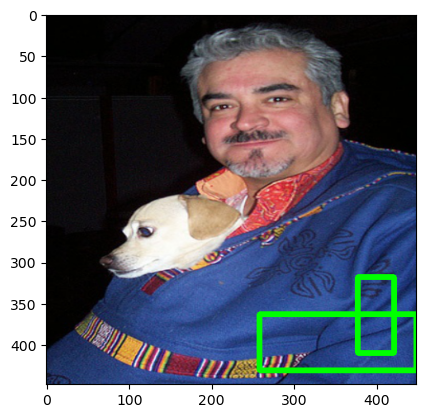

In [97]:
drawing(pred_img,nms_box)